In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from collections import OrderedDict
from scipy.stats import rayleigh
from sar_handler.image_processing import add_noise
sns.set()


In [17]:
# Path
ORIGINAL_NAME = "Исходное изображение"

PATHS = OrderedDict({
    ORIGINAL_NAME: Path("./original"),
    "Зашумлённое изображение": Path("./noised"),
    "Анизотропная диффузия": Path("./5_anisdiff"),
    "Регрессия с нормализацией": Path("./1_reg_norm"),
    "Регрессия без нормализации": Path("./2_reg_not_norm"),
    "Классификация с нормализацией": Path("./3_class_norm"),
    "Классификация без нормализации": Path("./4_class_not_norm"),
})
# ORIGINAL_IMAGES = Path("./original")
# NOISED_IMAGES = Path("./noised")
# ANIS_DIFF_IMAGES = Path("./anisdiff")
# CLASS_NORM_IMAGES = Path("./class/normalized")
# CLASS_NOT_NORM_IMAGES = Path("./class/not_normalized")
# REG_NORM_IMAGES = Path("./reg/normalized")
# REG_NOT_NORM_IMAGES = Path("./reg/not_normalized")

IMAGE_NAME = "5.jpg"
SLICE_INDEX = 350 # 400, 350

CROPED_IMAGES = Path("./cropped")
CROP_SIDES = (0, 100, 500, 400)
DIFFERENCE_PATH = Path("./difference")


In [3]:
def show_slice_line(img_name, paths, original_img_name, slice_index):
    img = np.array(Image.open(paths[original_img_name] / img_name))
    img[slice_index - 2:slice_index + 2] = 255
    Image.fromarray(img).save(paths[original_img_name] / ("slice_" + img_name))


show_slice_line(IMAGE_NAME, PATHS, ORIGINAL_NAME, SLICE_INDEX)

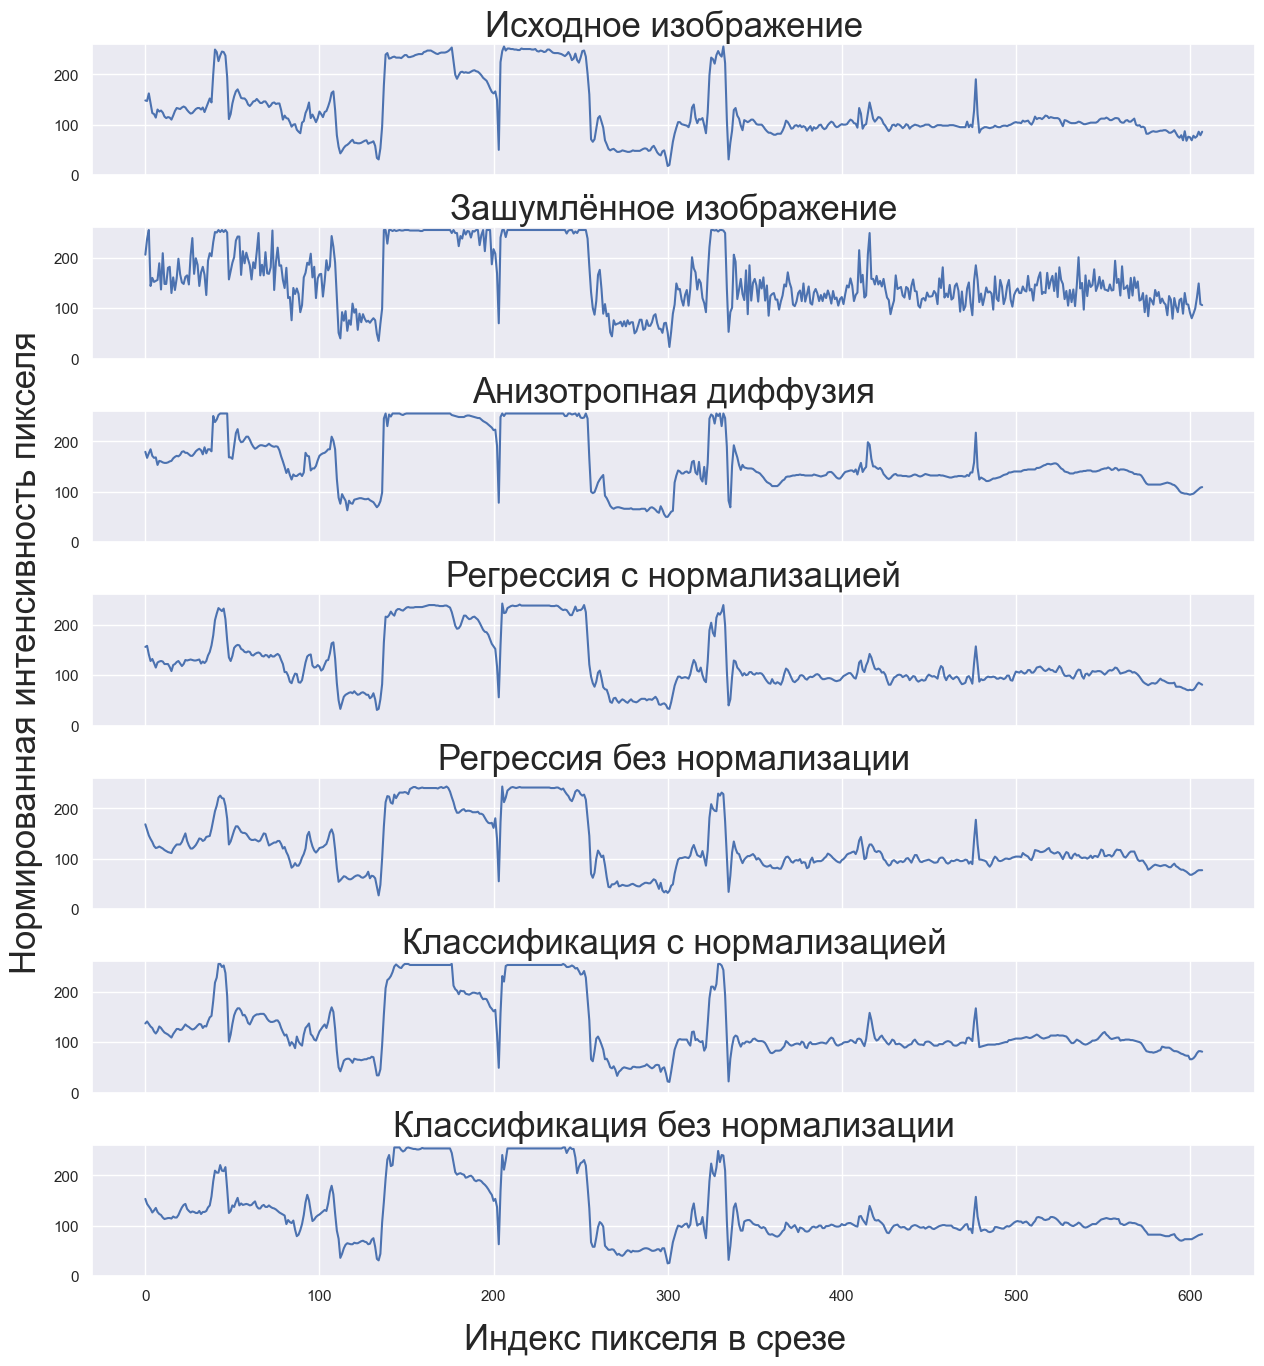

In [6]:
# Images slices
def plot_slices(img_name: str, paths: OrderedDict, slice_idx=200, title_fontsize=30, label_font_size=30):
    
    # Open image, convert to array, normalize
    images_list = [(np.array(Image.open(img / img_name))) for img in paths.values()]
    
    # Create list of slices
    y_list = np.array([img[slice_idx] for img in images_list])
    # plt.figure(figsize=(20, 10))
    
    fig, axs = plt.subplots(len(y_list), 1, sharex=True, figsize=(15, 16))
    plt.subplots_adjust(wspace=5, hspace=0.4)

    for ax, data, title in zip(axs, y_list, paths.keys()):
        ax.plot(data)
        ax.set_ylim(ymin=0, ymax=260)
        ax.set_title(title, fontsize=title_fontsize)
    fig.supxlabel('Индекс пикселя в срезе', y=0.06, fontsize=label_font_size)
    fig.supylabel('Нормированная интенсивность пикселя', x=0.07, fontsize=label_font_size)

    plt.show()    


plot_slices(IMAGE_NAME, PATHS, SLICE_INDEX, title_fontsize=25, label_font_size=25);

Mean: 0.00	Var: 0.00, Исходное изображение
Mean: 30.06	Var: 21.40, Зашумлённое изображение
Mean: 30.92	Var: 14.07, Анизотропная диффузия
Mean: -3.06	Var: 8.79, Регрессия с нормализацией
Mean: -2.39	Var: 8.94, Регрессия без нормализации
Mean: 0.22	Var: 8.60, Классификация с нормализацией
Mean: -0.93	Var: 9.37, Классификация без нормализации


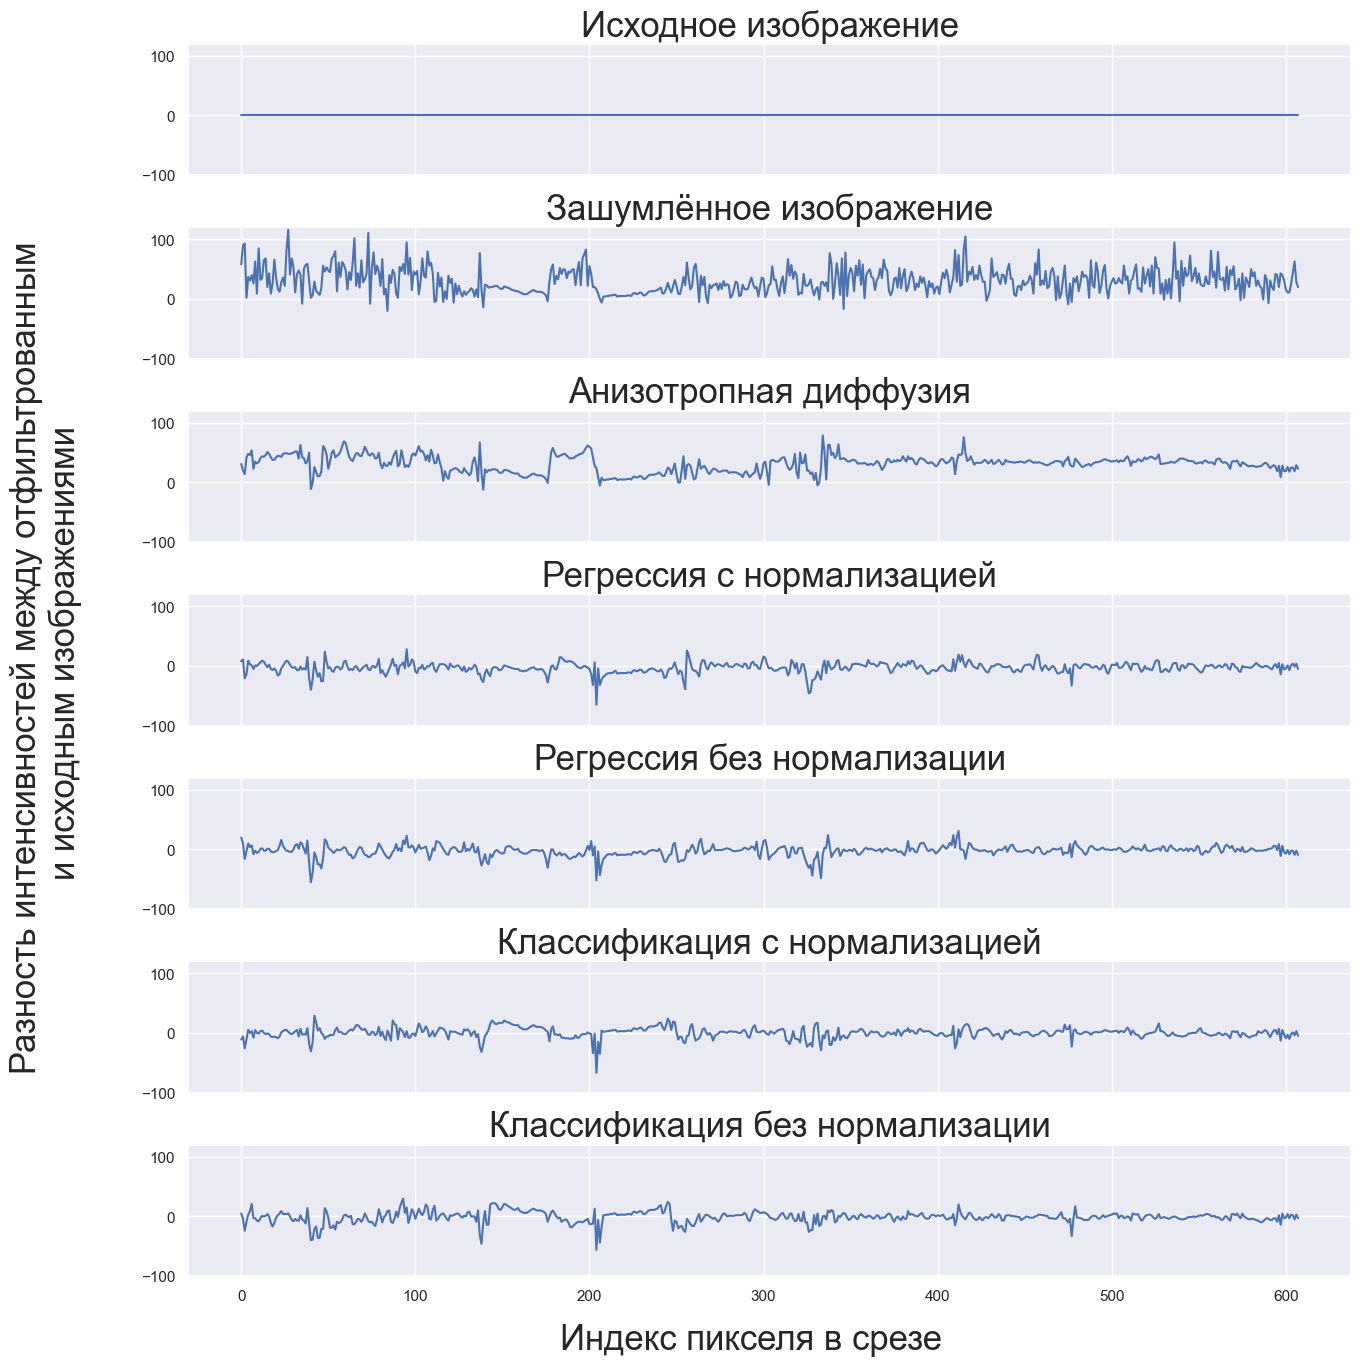

In [12]:
def plot_slices_subtrac_from_original(img_name: str, paths: OrderedDict, slice_idx=350, origin_name="Исходное изображение", title_fontsize=30, label_font_size=30):
    
    # Open image, convert to array, normalize
    images_list = [np.array(Image.open(img / img_name), dtype=np.int32) for img in paths.values()]
    
    # Open original image and get its slice
    original_img_slice = np.array(Image.open(paths[origin_name] / img_name), dtype=np.int32)[slice_idx]
    
    # Get slice, shift for y by some value, transpose arr
    y_list = np.array([(img[slice_idx] - original_img_slice) for img in images_list])
    fig, axs = plt.subplots(len(y_list), 1, sharex=True, figsize=(15, 16))

    plt.subplots_adjust(wspace=5, hspace=0.4)
    for ax, data, title in zip(axs, y_list, paths.keys()):
        print(f"Mean: {np.mean(data):.2f}\tStd: {np.std(data):.2f}, {title}")
        ax.plot(data)
        ax.set_ylim(ymin=-100, ymax=120)
        ax.set_title(title, fontsize=title_fontsize)
    fig.supxlabel('Индекс пикселя в срезе', y=0.06, fontsize=label_font_size)
    fig.supylabel('Разность интенсивностей между отфильтрованным \nи исходным изображениями', x=0.03, verticalalignment="center", horizontalalignment="center",  fontsize=label_font_size)

    plt.show()    
    

plot_slices_subtrac_from_original(IMAGE_NAME, PATHS, SLICE_INDEX, ORIGINAL_NAME, title_fontsize=25, label_font_size=25)

In [13]:
def images_var(img_name: str, paths: OrderedDict, origin_name="Исходное изображение"):
    
    # Open image, convert to array, normalize
    images_list = [np.array(Image.open(img / img_name), dtype=np.int32) for img in paths.values()]
    
    # Open original image and get its slice
    original_img_ = np.array(Image.open(paths[origin_name] / img_name), dtype=np.int32)
    
    # Get slice, shift for y by some value, transpose arr
    diff_list = np.array([(img - original_img_) for img in images_list])
    
    # fig, axs = plt.subplots(len(y_list), 1, sharex=True, figsize=(15, 15))
    for data, title in zip(diff_list, paths.keys()):
        print(f"Mean: {np.mean(data):.2f}\tVar: {np.std(data):.2f}, {title}")


images_var(IMAGE_NAME, PATHS, ORIGINAL_NAME)

Mean: 0.00	Var: 0.00, Исходное изображение
Mean: 34.34	Var: 21.99, Зашумлённое изображение
Mean: 34.98	Var: 13.14, Анизотропная диффузия
Mean: -1.66	Var: 9.64, Регрессия с нормализацией
Mean: -1.97	Var: 9.29, Регрессия без нормализации
Mean: -1.70	Var: 9.46, Классификация с нормализацией
Mean: -1.47	Var: 9.33, Классификация без нормализации


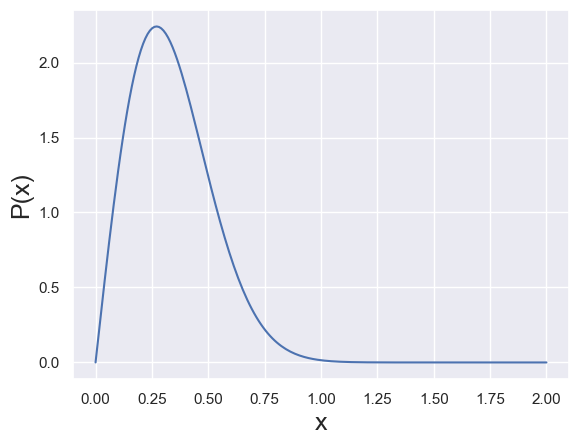

In [83]:
def rayleigh(x, scale):
    return x / (scale * scale) * np.exp((-x * x) / (2 * scale * scale))


def create_distr(scale=0.2707, points=200) -> np.array:
    x = np.linspace(0, 2, points)
    y = rayleigh(x, scale)
    # Add noise
    plt.plot(x, y)
    plt.xlabel("x", fontsize=18)
    plt.ylabel("P(x)", fontsize=18)
    plt.show()
    # return noised_img
create_distr()

In [84]:
def crop_imgs(image_name, paths, out_path, crop_sides):
    imgs = [Image.open(path / image_name) for path in paths.values()]
    croped_images = [image.crop(crop_sides) for image in imgs]
    [croped_image.save(out_path / (name + ".jpg")) for croped_image, name in zip(croped_images, paths.keys())]


crop_imgs("5.jpg", PATHS, CROPED_IMAGES, CROP_SIDES)

In [14]:
def crop_and_save(image_name, path, crop_sides, out_path=CROPED_IMAGES, new_name=""):
    img = Image.open(path / image_name)
    croped_image = img.crop(crop_sides)
    croped_image.save(CROPED_IMAGES / ("cropped_" + new_name + image_name))


In [15]:
sar_path = Path(r"D:\Projects\PythonProjects\NIR\results\sar_images")
sar_image_name = "ICEYE_ARCHIVE_SL_25164_20200323T011055.png"
sides = (100, 100, 700, 500)
crop_and_save(sar_image_name, sar_path, sides)

for img_path, img_new_name in zip(PATHS.values(), PATHS.keys()):
    try:
        crop_and_save(sar_image_name, img_path, sides, new_name=img_new_name)
    except FileNotFoundError as e:
        print(e)

[Errno 2] No such file or directory: 'D:\\Projects\\PythonProjects\\NIR\\results\\original\\ICEYE_ARCHIVE_SL_25164_20200323T011055.png'
[Errno 2] No such file or directory: 'D:\\Projects\\PythonProjects\\NIR\\results\\noised\\ICEYE_ARCHIVE_SL_25164_20200323T011055.png'


In [23]:
def deffrence_between_images(path1, img_name_1, path2, img_name_2, out_path, img_new_name):
    img1 = np.array(Image.open(path1 / img_name_1), dtype=np.int32)
    img2 = np.array(Image.open(path2 / img_name_2), dtype=np.int32)
    diff = np.abs(img1 - img2)
    diff = np.where(diff >= 255, 255, diff)
    # diff = np.where(diff < 0, 0, diff)
    diff = diff.astype(np.uint8)
    diff = Image.fromarray(diff)
    diff.save(DIFFERENCE_PATH / ("diff" + img_name_1 + "_AND_" + img_new_name + ".jpg"))

path1 = Path("./original")
for img_path, img_new_name in zip(PATHS.values(), PATHS.keys()):
    deffrence_between_images(path1, IMAGE_NAME, img_path, IMAGE_NAME, DIFFERENCE_PATH, img_new_name)